In [29]:
use_gpu = True # Set to False to use CPU
dev = str(2) 

import os
if use_gpu:
    try:
        import cupy as xp
        from cupyx.scipy.interpolate import Akima1DInterpolator as stock_akima
        os.environ["OMP_NUM_THREADS"] = str(1)
        os.system("OMP_NUM_THREADS=1")
        os.system("CUDA_VISIBLE_DEVICES=" + dev)
        os.environ["CUDA_VISIBLE_DEVICES"] = dev
        os.system("echo $CUDA_VISIBLE_DEVICES")

        os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=1'
    except:
        print('No GPUs available, using CPUs')
        import numpy as np
        from scipy.interpolate import Akima1DInterpolator as stock_akima

else:
    import numpy as xp
    from scipy.interpolate import Akima1DInterpolator as stock_akima

import numpy as np
import matplotlib.pyplot as plt
from cudakima import AkimaInterpolant1D

2


In [30]:
# just for plotting purposes
def to_cpu(x):
    try:
        return x.get()
    except:
        return x

## Getting started

In [31]:
interp = AkimaInterpolant1D(sanitize=True, use_gpu=use_gpu, threadsperblock=128)

### Arrays of equal shape

In [32]:
# Generate some random data
xmin, xmax = 0, 10 # X Domain
ymin, ymax = -100, 100 # Y Domain
npoints = 10 # Number of points
nrealizations = 100 # Number of realizations

x = xp.random.random(size=(nrealizations, npoints)) * (xmax - xmin) + xmin
# Make sure the first and last points are the same
x[:, 0] = xmin
x[:, -1] = xmax
y = xp.random.random(size=(nrealizations, npoints)) * (ymax - ymin) + ymin


# Define the x values to interpolate
xinterp = xp.linspace(xmin, xmax, 1000)

In [33]:
result = interp(xinterp, x, y)

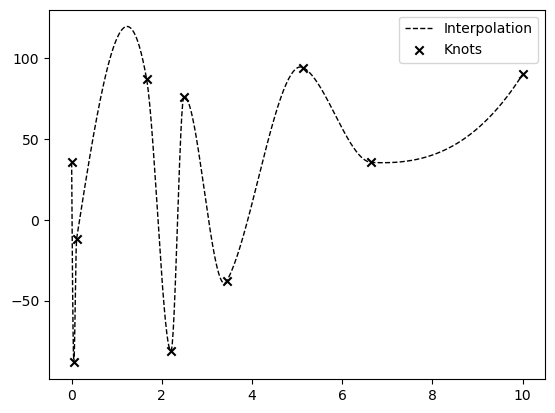

In [34]:
realization = 7

plt.plot(to_cpu(xinterp), to_cpu(result)[realization], c='k', ls = '--', lw=1, label='Interpolation')
plt.scatter(to_cpu(x)[realization], to_cpu(y)[realization], marker='x', c='k', label='Knots')

plt.legend()
plt.show()

### Arrays of different shapes

You can combine arrays of different shapes padding them with `xp.nan` and stacking them together

In [35]:
# generate random arrays as before, but fill some of them with nans
x = xp.random.random(size=(nrealizations, npoints)) * (xmax - xmin) + xmin
# Make sure the first and last points are the same
x[:, 0] = xmin
x[:, -4] = xmax
y = xp.random.random(size=(nrealizations, npoints)) * (ymax - ymin) + ymin

x[0, -3:] = xp.nan
x[1, -2:] = xp.nan
x[2, -1:] = xp.nan

y[0, -3:] = xp.nan
y[1, -2:] = xp.nan
y[2, -1:] = xp.nan

In [37]:
result = interp(xinterp, x, y)

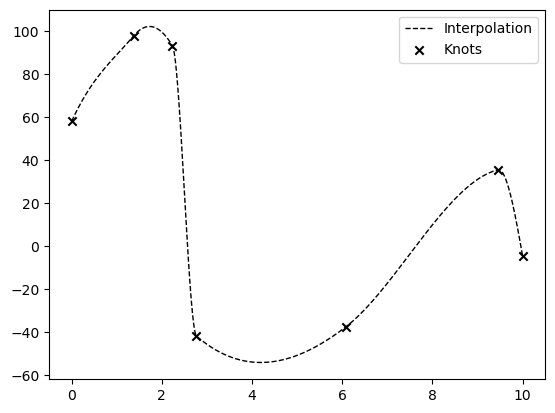

In [38]:
realization = 0

plt.plot(to_cpu(xinterp), to_cpu(result)[realization], c='k', ls = '--', lw=1, label='Interpolation')
plt.scatter(to_cpu(x)[realization], to_cpu(y)[realization], marker='x', c='k', label='Knots')

plt.legend()
plt.show()

### arrays containing less than 4 points

The boundary conditions currently implemented require at least 4 points in the interpolation grid. If there are less then 4 non-NaN values, the code falls back on *linear interpolation* between them.

In [51]:
# generate random arrays as before, but fill some of them with nans
x = xp.random.random(size=(nrealizations, npoints)) * (xmax - xmin) + xmin
# Make sure the first and last points are the same
x[:, 0] = xmin
x[:, 1] = xmax
y = xp.random.random(size=(nrealizations, npoints)) * (ymax - ymin) + ymin

# introduce a case with only 2 grid points and one with 3 grid points

x[0, 2:] = xp.nan
x[1, 3:] = xp.nan
x[2, 4:] = xp.nan

y[0, 2:] = xp.nan
y[1, 3:] = xp.nan
y[2, 4:] = xp.nan

In [52]:
result = interp(xinterp, x, y)

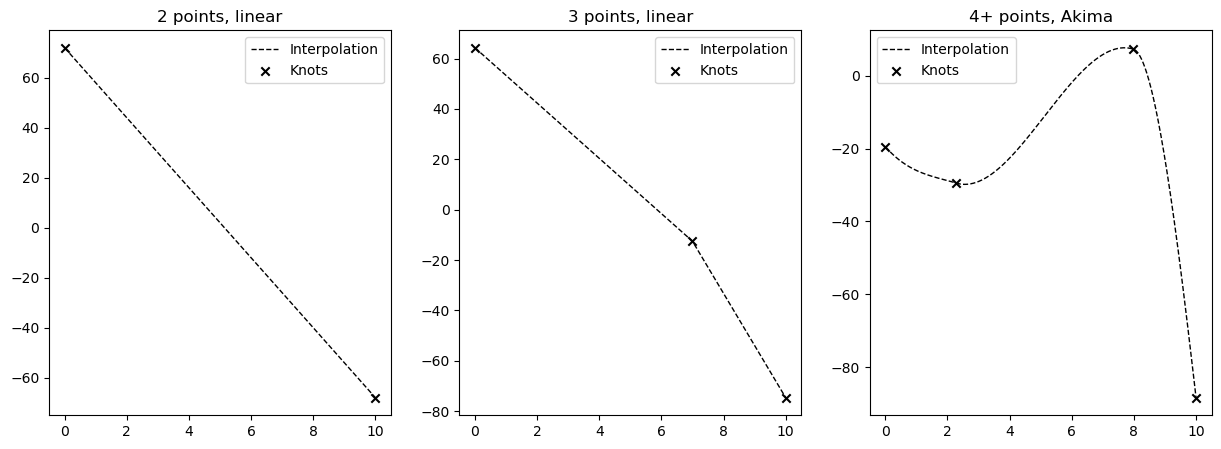

In [53]:
fig = plt.figure(figsize=(15, 5))

titles = ['2 points, linear', '3 points, linear', '4+ points, Akima']

for realization, title in zip(range(3), titles):
    
    plt.subplot(1, 3, realization + 1)

    plt.plot(to_cpu(xinterp), to_cpu(result)[realization], c='k', ls = '--', lw=1, label='Interpolation')
    plt.scatter(to_cpu(x)[realization], to_cpu(y)[realization], marker='x', c='k', label='Knots')
    plt.title(title)

    plt.legend()
plt.show()

### Comparison with Cubic Splines

In [43]:
from scipy.interpolate import CubicSpline

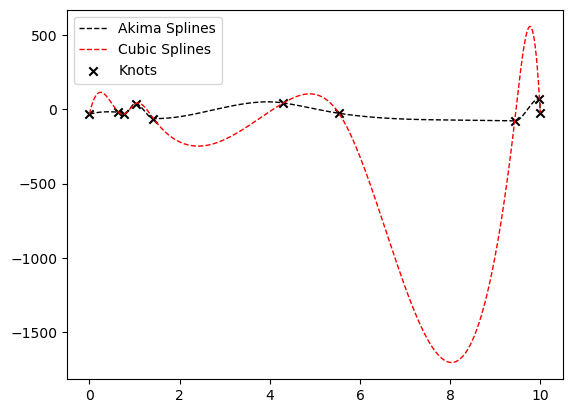

In [44]:
realization = 5 # Choose a realization without NaNs

xhere = to_cpu(x[realization])
yhere = to_cpu(y[realization])
resulthere = to_cpu(result[realization])

#sort the arrays
idx = np.argsort(xhere)
xhere = xhere[idx]
yhere = yhere[idx]

cs = CubicSpline(xhere, yhere)
resultcs = cs(to_cpu(xinterp))

plt.plot(to_cpu(xinterp), to_cpu(result)[realization], c='k', ls = '--', lw=1, label='Akima Splines')
plt.plot(to_cpu(xinterp), resultcs, c='r', ls = '--', lw=1, label='Cubic Splines')
plt.scatter(to_cpu(x)[realization], to_cpu(y)[realization], marker='x', c='k', label='Knots')

plt.legend()
plt.show()

Akima splines show **smoother** behaviour with respect to Cubic Splines

## Timing against the stock implementation in Scipy / Cupy

In [45]:
# Generate some random data
xmin, xmax = 0, 10 # X Domain
ymin, ymax = -100, 100 # Y Domain
npoints = 10 # Number of points
nrealizations = 100 # Number of realizations

x = xp.random.random(size=(nrealizations, npoints)) * (xmax - xmin) + xmin
# Make sure the first and last points are the same
x[:, 0] = xmin
x[:, -1] = xmax
y = xp.random.random(size=(nrealizations, npoints)) * (ymax - ymin) + ymin

# Sort the array, cupy and scipy demand sorted x values
x = xp.sort(x, axis=1)

# Define the x values to interpolate
xinterp = xp.linspace(xmin, xmax, 1000)

In [46]:
def stock_interpolator(x, x_all, y_all):

    result = xp.empty((len(x_all), len(x)))
    for i, (x_here, y_here) in enumerate(zip(x_all, y_all)):
        interpolator = stock_akima(x_here, y_here)
        result[i] = interpolator(x)
    return result


In [47]:
cudakima_interpolator = AkimaInterpolant1D(sanitize=False, use_gpu=use_gpu, threadsperblock=128)

In [48]:
%%timeit
#time cudakima
result_cudakima = cudakima_interpolator(xinterp, x, y)

1 ms ± 3.09 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [49]:
%%timeit
# time stock scipy / cupy
result_stock = stock_interpolator(xinterp, x, y)

237 ms ± 5.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


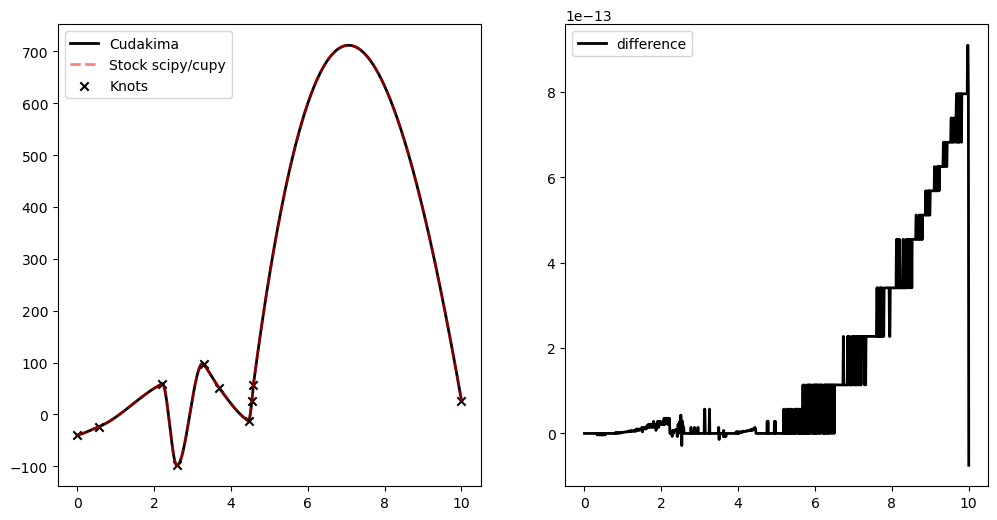

In [50]:
result_cudakima = to_cpu(cudakima_interpolator(xinterp, x, y))
result_stock = to_cpu(stock_interpolator(xinterp, x, y))

realization = np.random.randint(0, nrealizations)
fig = plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(to_cpu(xinterp), result_cudakima[realization], c='k', ls = '-', lw=2, label='Cudakima')
plt.plot(to_cpu(xinterp), result_stock[realization], c='red', ls = '--', lw=2, label='Stock scipy/cupy', alpha=0.5)
plt.scatter(to_cpu(x)[realization], to_cpu(y)[realization], marker='x', c='k', label='Knots')
plt.legend()
plt.subplot(122)
plt.plot(to_cpu(xinterp), result_cudakima[realization] - result_stock[realization], c='k', ls = '-', lw=2, label='difference')

plt.legend()
plt.show()